In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

In [37]:
def summarize(alpha=0.05):
    
    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })
    
    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )

All practice problems to follow use the same data. Pull out the old `Howell !Kung [Howell1]` demography
data and split it into two equally sized data frames.

In [3]:
data = pd.read_csv('../data/Howell1.csv', sep=';')
data = data.assign(age = (data.age - data.age.mean()) / data.age.std() )
data = data[['height', 'age']]
d1 = data.sample(frac=.5, random_state=100)
d2 = data.drop(d1.index).reset_index(drop=True)
d1 = d1.reset_index(drop=True)

You now have two randomly formed data frames, each with 272 rows. The notion here is to use the cases in `d1` to fit models and the cases in `d2` to evaluate them. Now let `hi` and `xi` be the height and centered age values, respectively, on row `i`. Fit the following models to the data in `d1`:

```

    M1
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi

    M2
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2

    M3
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2 + β3 xi^3

    M4
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2 + β3 xi^3 + β4 xi^4

    M5
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2 + β3 xi^3 + β4 xi^4 + β5 xi^5

    M6
    hi ∼ Normal(μi , σ)
    μi = α + β1 xi + β2 xi^2 + β3 xi^3 + β4 xi^4 + β5 xi^5 + β6 xi^6
```

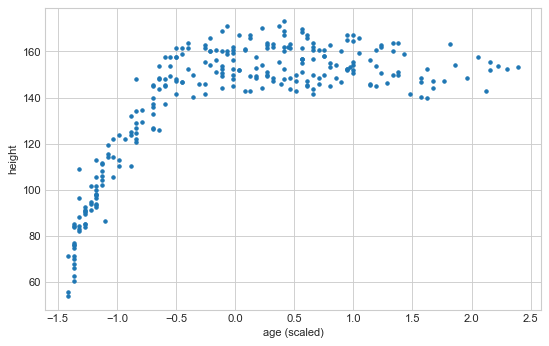

In [6]:
plt.figure(figsize=(8, 5), dpi=80)
plt.scatter(d1.age, d1.height, marker='.')
plt.gca().set(xlabel='age (scaled)', ylabel='height')
None

In [11]:
models = []

for N in [1, 2, 3, 4, 5, 6]:

    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=d1.height.mean(), sd=10)
        beta = pm.Normal('beta', mu=0, sd=10, shape=N)
        
        _mu = alpha
        _mu_pred = alpha

        for i in range(N):
            _mu = _mu + beta[i] * np.power(d1.age, i+1)
            _mu_pred = _mu_pred + beta[i] * np.power(d2.age, i+1)

        height = pm.Deterministic('height', _mu)
        sigma = pm.HalfCauchy('sigma', beta=10)
        height_obs = pm.Normal('height_obs', mu=height, sd=sigma, observed=d1.height)

        height_pred = pm.Deterministic('height_pred', _mu_pred)

        model.name = f'M{N}'
        model.trace = pm.sample(5000, tune=500, chains=2)

    models.append(model)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:09<00:00, 1190.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:12<00:00, 905.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.46draws/s]
The acceptance probability does not match the target. It is 0.8793534475417774, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|████████

**H1** Compare the models above, using WAIC. Compare the model rankings, as well as the WAIC weights.


In [14]:
pm.compare(
    {model: model.trace for model in models},
    method='BB-pseudo-BMA'
)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
M4,1898.73,5.17,0,0.51,21.9,0,1
M5,1900.46,5.92,1.73,0.23,22.19,1.99,1
M6,1900.6,6.76,1.87,0.24,22.16,2.35,1
M3,1917.88,4.72,19.15,0.02,21.44,8.98,0
M2,2112.56,5.4,213.83,0,22.26,25.98,1
M1,2391.54,3.22,492.8,0,20.12,28.4,0


**H2** For each model, produce a plot with model averaged mean and 97% confidence interval of the mean, superimposed on the raw data. How do predictions differ across models?


In [21]:
summaries = {}

for model in models:
    summary = agg_prediction(model.trace['height'], d1, ['age'], summarize(0.03))
    summaries[model.name] = summary

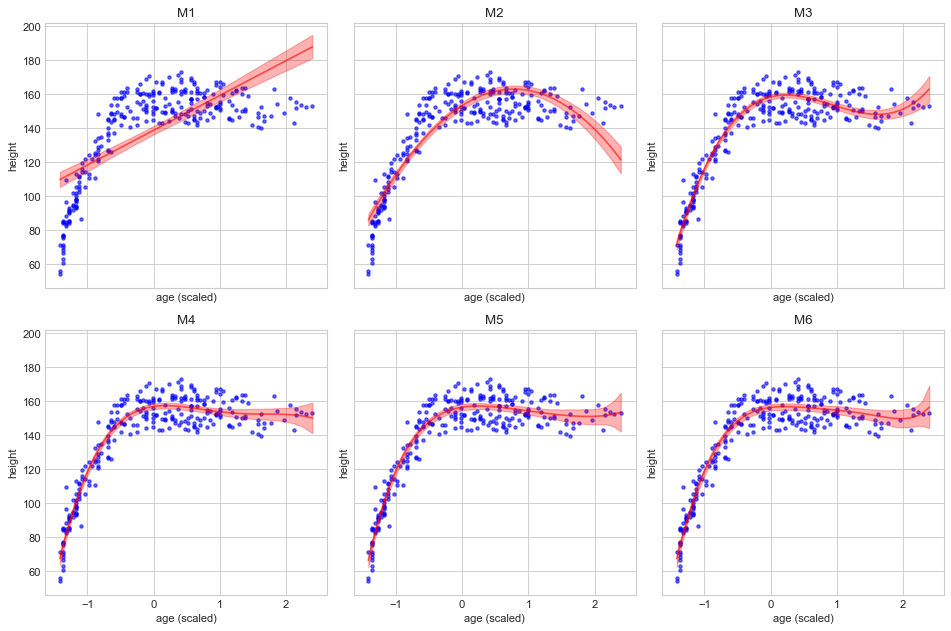

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=80,
                         sharex=True, sharey=True)

axes = axes.reshape(-1)

for ax, (model_name, summary) in zip(axes, summaries.items()):
    ax.scatter(d1.age, d1.height, color='b', alpha=.6, marker='.')

    ax.plot(summary.age, summary.mean_, color='r', alpha=.6)
    ax.fill_between(summary.age, summary.lower, summary.upper,
                    color='r', alpha=.3)

    ax.set(title=model_name, xlabel='age (scaled)', ylabel='height',
           facecolor='w')

fig.tight_layout()
None    

**6H3** Now also plot the model averaged predictions, across all models. In what ways do the averaged predictions differ from the predictions of the model with the lowest WAIC value?


In [39]:
pred_summaries = {}

for model in models:
    summary = agg_prediction(model.trace['height_pred'], d2, ['age'], summarize(0.03))
    pred_summaries[model.name] = summary

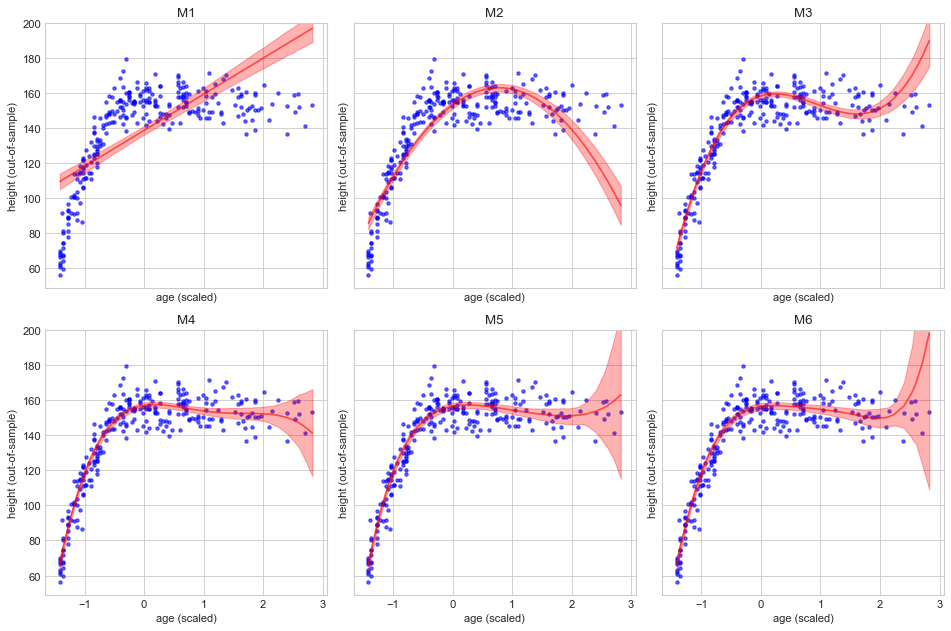

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=80,
                         sharex=True, sharey=True)

axes = axes.reshape(-1)

for ax, (model_name, summary) in zip(axes, pred_summaries.items()):
    ax.scatter(d2.age, d2.height, color='b', alpha=.6, marker='.')

    ax.plot(summary.age, summary.mean_, color='r', alpha=.6)
    ax.fill_between(summary.age, summary.lower, summary.upper,
                    color='r', alpha=.3)

    ax.set(title=model_name, xlabel='age (scaled)', ylabel='height (out-of-sample)',
           facecolor='w', ylim=(None, 200))

fig.tight_layout()
None    